# Facebook Prophet
**Content:**
- Google Colab Setup
- Preprocessing
- Modeling
- Evaluation and Conclusion

In [1]:
# util.py has pmdarima function inside
# Need to install it before import the pyfile
# !pip install pmdarima

In [2]:
# Google Colab
from google.colab import drive
import os

# General
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')

# Facebook Prophet
from fbprophet import Prophet
from fbprophet.plot import plot, plot_plotly, plot_components_plotly

## I. Google Colab Setup

In [3]:
# Mount Google Drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [4]:
# Get the current working directory
print(os.getcwd())

/content


In [5]:
# Drive path is the path where I upload the ETFs history file and pre-written pyfile
drive_path_csv = '/gdrive/MyDrive/Capstone_Project/REIT_ETFs.csv'
drive_path_util = '/gdrive/MyDrive/Capstone_Project/util.py'

# Expect to move these file into the local path
local_path = '/content'

In [6]:
# Copy these file in drive path
!cp '{drive_path_csv}' .
!cp '{drive_path_util}' .

# Change these file from drive path to the local path
os.chdir(local_path)

In [7]:
# Pre-written function
import util as ut

## II. Preprocessing

In [8]:
data = pd.read_csv('/content/REIT_ETFs.csv')
data

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker
0,2004-09-29,23.794544,23.861371,23.789772,23.794544,205800,0.0,0.0,VNQ
1,2004-09-30,23.866143,24.023660,23.861370,23.985474,27900,0.0,0.0,VNQ
2,2004-10-01,24.033207,24.462799,23.985476,24.429386,129800,0.0,0.0,VNQ
3,2004-10-04,24.529629,24.606000,24.529629,24.534403,8100,0.0,0.0,VNQ
4,2004-10-05,24.534403,24.582135,24.510535,24.529629,11900,0.0,0.0,VNQ
...,...,...,...,...,...,...,...,...,...
53434,2021-06-17,9.280000,9.290000,9.220000,9.220000,5200,0.0,0.0,REK
53435,2021-06-18,9.330000,9.370000,9.270000,9.370000,22800,0.0,0.0,REK
53436,2021-06-21,9.320000,9.320000,9.170000,9.170000,22900,0.0,0.0,REK
53437,2021-06-22,9.160000,9.230000,9.160000,9.220000,6200,0.0,0.0,REK


In [9]:
# Select one REIT ETF
vnq = data.copy().loc[data['Ticker'] == "VNQ"]

- The [*fbprophet*](https://facebook.github.io/prophet/docs/quick_start.html) library imposes strict condition that a dataframe with 2 columns: 
    - <b>ds</b> - the datestamp column
    - <b>y</b> - the metric column

In [10]:
# Drop unnecessary columns
list1 = vnq.columns[1:4].tolist()
list2 = vnq.columns[-4:].tolist()
drop_col = list1 + list2
drop_col

['Open', 'High', 'Low', 'Volume', 'Dividends', 'Stock Splits', 'Ticker']

In [11]:
vnq.drop(columns=drop_col, inplace=True)

In [12]:
# Change the "Date" column to datetime64
vnq['Date'] = pd.DatetimeIndex(vnq['Date'])

In [13]:
# Rename the column
vnq.rename(columns={'Date' : 'ds',
                    'Close' : 'y'}, inplace=True)

In [14]:
vnq

,ds,y
0,2004-09-29,23.794544
1,2004-09-30,23.985474
2,2004-10-01,24.429386
3,2004-10-04,24.534403
4,2004-10-05,24.529629
...,...,...
4208,2021-06-17,103.550003
4209,2021-06-18,101.790001
4210,2021-06-21,103.889999
4211,2021-06-22,103.349998


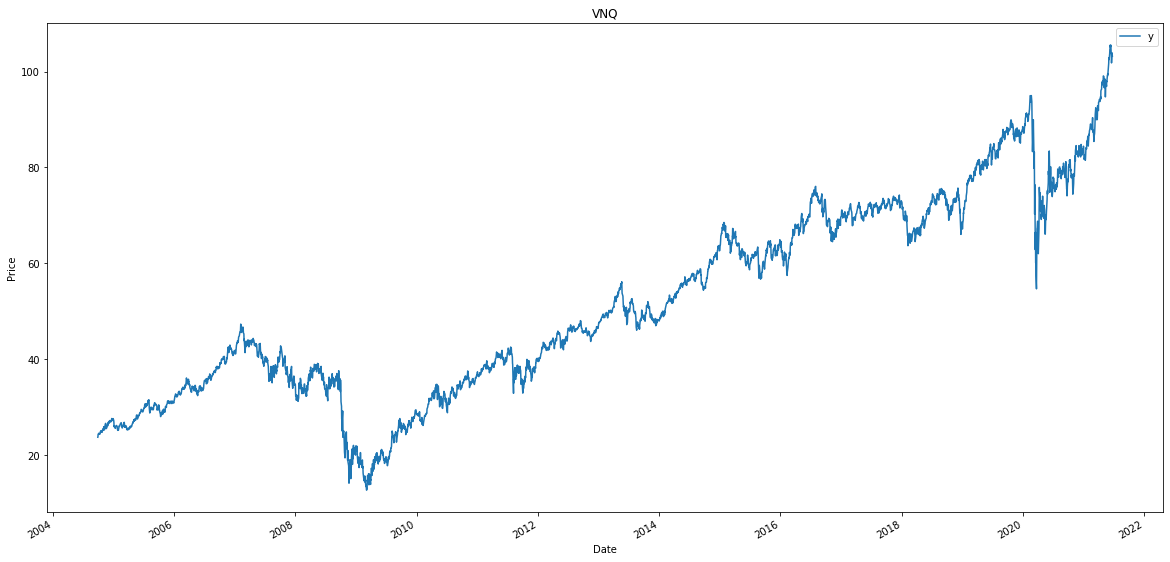

In [15]:
# Plot the time series 
ax = vnq.set_index('ds').plot(figsize=(20, 10))
ax.set_title("VNQ")
ax.set_xlabel('Date')
ax.set_ylabel('Price')
plt.show()

## III. Modeling

In [16]:
# Train test split
train = vnq.iloc[:-21]
test = vnq.iloc[-21:] # holdout set for model evaluation

### Baseline Model

In [17]:
# Instantiate the FB Prophet model
base_model = Prophet(interval_width=0.95)  # set the uncertainty interval to 95%

In [18]:
# Fit the model
base_model.fit(train)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [19]:
# Test date range
print(test.ds.min())
print(test.ds.max())

2021-05-25 00:00:00
2021-06-23 00:00:00


In [20]:
# Create future dates which match with the test set
future_dates = base_model.make_future_dataframe(periods=22, freq='B', include_history=True)
future_dates.tail(22)

,ds
4192,2021-05-25
4193,2021-05-26
4194,2021-05-27
4195,2021-05-28
4196,2021-05-31
4197,2021-06-01
4198,2021-06-02
4199,2021-06-03
4200,2021-06-04
4201,2021-06-07


In [21]:
# Predict the values for future dates
forecast = base_model.predict(future_dates)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
4209,2021-06-17,88.013450,80.872845,95.243706,87.900674,88.069789,-0.031613,-0.031613,-0.031613,0.086233,0.086233,0.086233,-0.117846,-0.117846,-0.117846,0.0,0.0,0.0,87.981837
4210,2021-06-18,88.027296,81.042838,95.013383,87.905833,88.093202,0.015409,0.015409,0.015409,0.146829,0.146829,0.146829,-0.131420,-0.131420,-0.131420,0.0,0.0,0.0,88.042705
4211,2021-06-21,88.068834,81.327500,95.169445,87.915132,88.162622,-0.048572,-0.048572,-0.048572,0.123813,0.123813,0.123813,-0.172384,-0.172384,-0.172384,0.0,0.0,0.0,88.020262
4212,2021-06-22,88.082680,80.767559,95.367841,87.917773,88.185762,-0.022683,-0.022683,-0.022683,0.162105,0.162105,0.162105,-0.184788,-0.184788,-0.184788,0.0,0.0,0.0,88.059997
4213,2021-06-23,88.096526,80.812803,95.129620,87.920602,88.209031,-0.093685,-0.093685,-0.093685,0.102161,0.102161,0.102161,-0.195846,-0.195846,-0.195846,0.0,0.0,0.0,88.002841


In [22]:
# Subset above mentioned columns and view the tail 
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
4209,2021-06-17,87.981837,80.872845,95.243706
4210,2021-06-18,88.042705,81.042838,95.013383
4211,2021-06-21,88.020262,81.327500,95.169445
4212,2021-06-22,88.059997,80.767559,95.367841
4213,2021-06-23,88.002841,80.812803,95.129620


In [23]:
ut.evaluate(test['y'], forecast['yhat'].tail(21))

MAE: 14.9179
RMSE: 15.0398
R^2: -57.5745


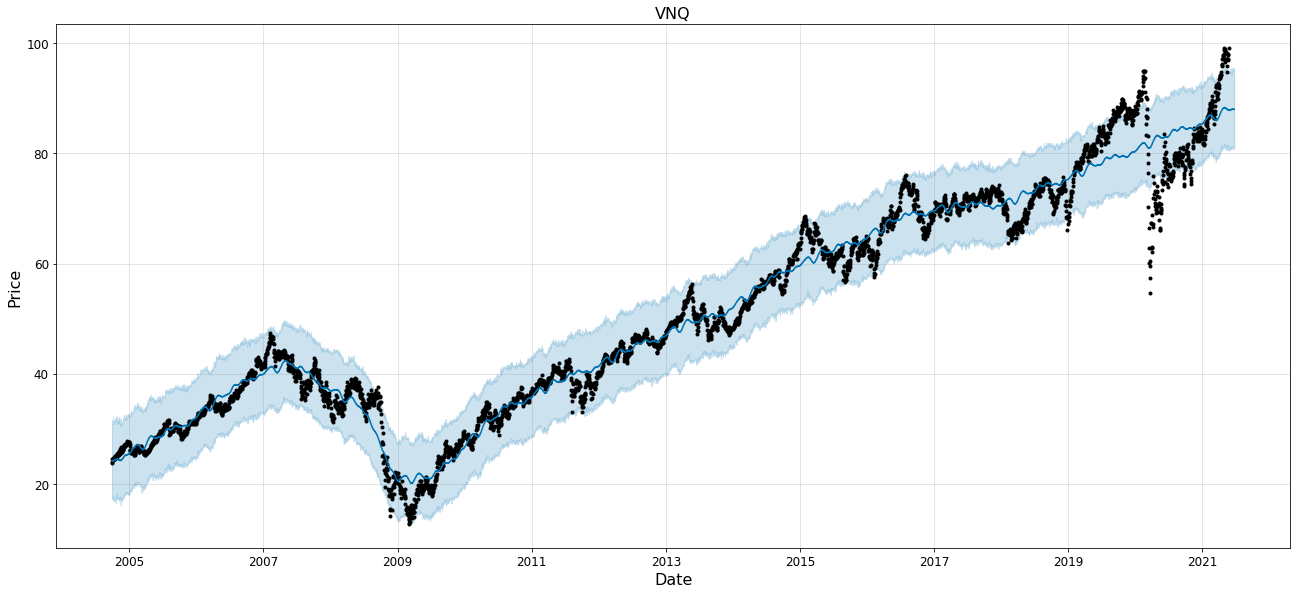

In [24]:
# Visualize the prediction
fig = plot(base_model, forecast, uncertainty=True, figsize=(18, 8))
ax = fig.gca()
ax.set_title("VNQ", size=16)
ax.set_xlabel("Date", size=16)
ax.set_ylabel("Price", size=16)
ax.tick_params(axis="x", labelsize=12)
ax.tick_params(axis="y", labelsize=12)
plt.savefig('fbprophet_result', dpi=300, bbox_inches='tight')
plt.show()

>**Comment:**
- MAE (14.9179) and RMSE (15.0398) are relative high
- R2 is -57.5745
- The plot shows that the base model can only detect trend and did poorly on predicting the actual price

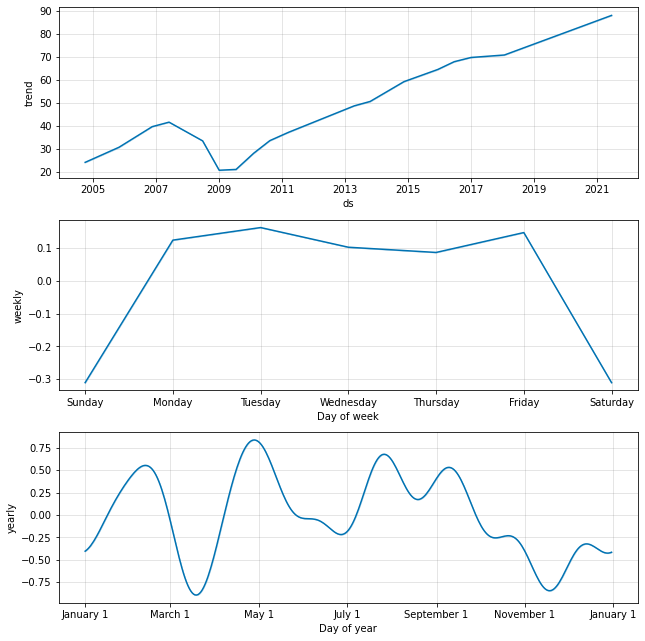

In [25]:
# Visualize components
base_model.plot_components(forecast)
plt.show()

>**Comment:**
- The base model shows there are weekly and yearly seasonality

In [26]:
# plot_components_plotly(base_model, forecast)
# plot_plotly(base_model, forecast)

### Tuning Model

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 14.0642
RMSE: 14.1862
R^2: -51.1142


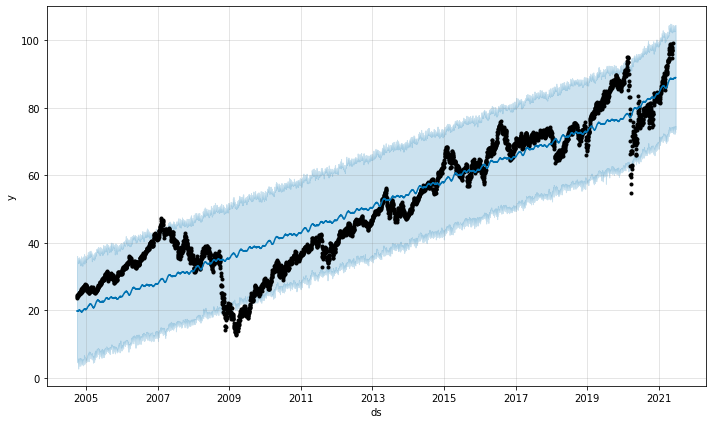

In [27]:
m2 = Prophet(interval_width=0.95, changepoints='2020-03-23') # 2020-03-23 is the lowest in 2020 => high relationship with COVID
m2.fit(train)
fc = m2.predict(future_dates)

ut.evaluate(test['y'], fc['yhat'].tail(21))

x = m2.plot(fc, uncertainty=True)

>**Comment:**
- Compare to baseline model, after adding a change point, the model performance shows slightly improvement. However, the model becomes less likely to detect the trend

In [28]:
def fb_model(season_yr=False, season_w=False, pd_yr=None, pd_w=None, fo_yr=None, fo_w=None):
    '''
    Define a FBProphet model with custom year and/or week seasonality

    -*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*

    Inputs:
    - season_yr: year seasonality
    - season_w: week seasonality
    - pd_yr: number of days
    - pd_w: number of days
    - fo_yr: year fourier order
    - fo_w: week fourier order

    Output:
    - Customer FBProphet model evaluation results and plot

    '''

    # Instantiate the model
    model = Prophet(interval_width=0.95)
    
    if season_yr == True:
        model.add_seasonality(name='yearly', period=pd_yr, fourier_order=fo_yr)
    
    if season_w == True:
        model.add_seasonality(name='weekly', period=pd_w, fourier_order=fo_w)

    # Fit the model
    model.fit(train)
    
    # Prediction
    future_dates = model.make_future_dataframe(periods=22, freq='B', include_history=True)
    forecast = model.predict(future_dates)

    # Plot
    model.plot(forecast, uncertainty=True)
    # model.plot_components(forecast)
    plt.show()

    # Evaluate between test the pred
    ut.evaluate(test['y'], forecast['yhat'].tail(21))

INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


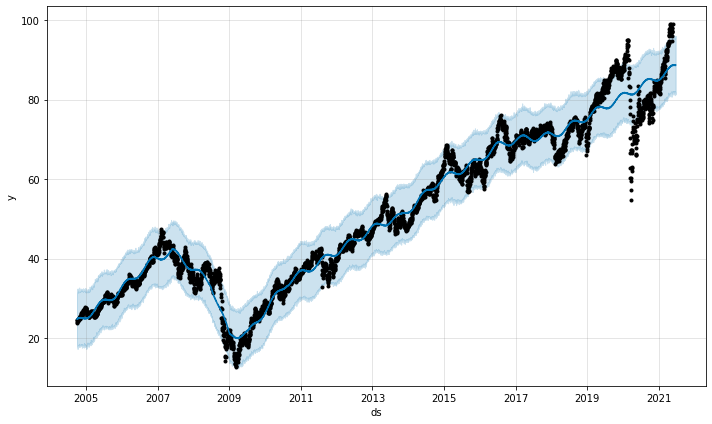

MAE: 14.2151
RMSE: 14.3481
R^2: -52.3110


In [29]:
m3 = fb_model(season_yr=True, season_w=True, pd_yr=253, pd_w=5, fo_yr=1, fo_w=1)

INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


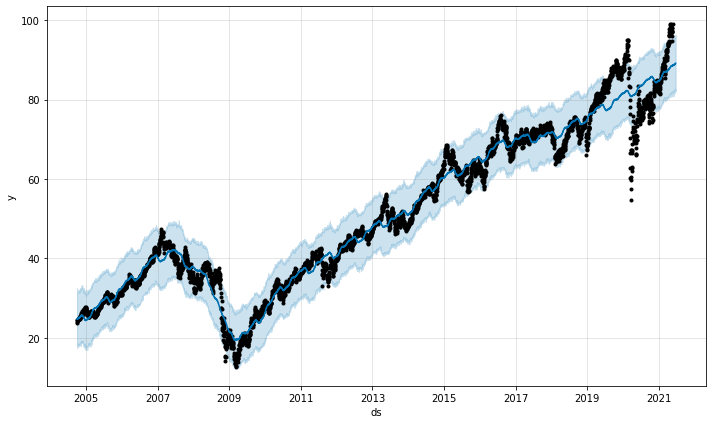

MAE: 14.0718
RMSE: 14.1954
R^2: -51.1823


In [30]:
m4 = fb_model(season_yr=True, season_w=True, pd_yr=253, pd_w=5, fo_yr=5, fo_w=5)

INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


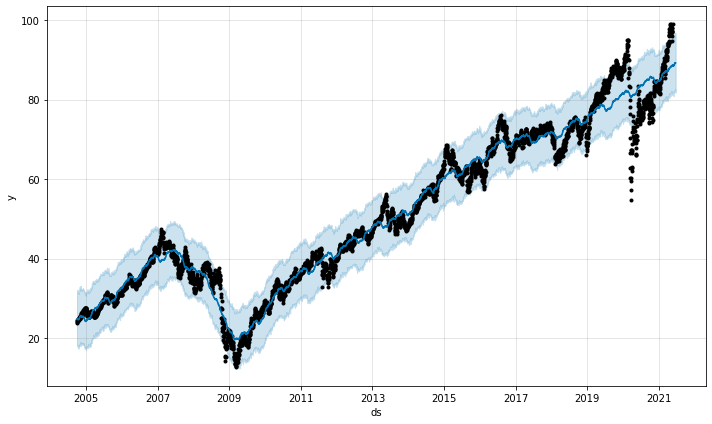

MAE: 14.0614
RMSE: 14.1760
R^2: -51.0399


In [31]:
model_3 = fb_model(season_yr=True, season_w=True, pd_yr=253, pd_w=5, fo_yr=10, fo_w=10)

>**Comment:**
- Manually adding seasonality can slightly improve the model performance, yet the MAE and RMSE are still high

## IV. Evaluation and Conclusion
- Although FBProphet model can detect the trend, it is not a good choice for predicting ETF's future price
- The MAE and RMSE remain relative high after model tuning